In [15]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Runge function and its derivative
def runge_function(x):
    return 1 / (1 + 25 * x**2)

def runge_derivative(x):
    return (-50 * x) / (1 + 25 * x**2)**2

# Dataset
X = np.linspace(-1, 1, 200).reshape(-1, 1).astype(np.float32)
y = runge_function(X).astype(np.float32)
dy = runge_derivative(X).astype(np.float32)

# Add the derivative to the target
X_train, X_val, y_train, y_val, dy_train, dy_val = train_test_split(
    X, y, dy, test_size=0.2, random_state=42
)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
dy_train_tensor = torch.tensor(dy_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
dy_val_tensor = torch.tensor(dy_val)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, dy_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

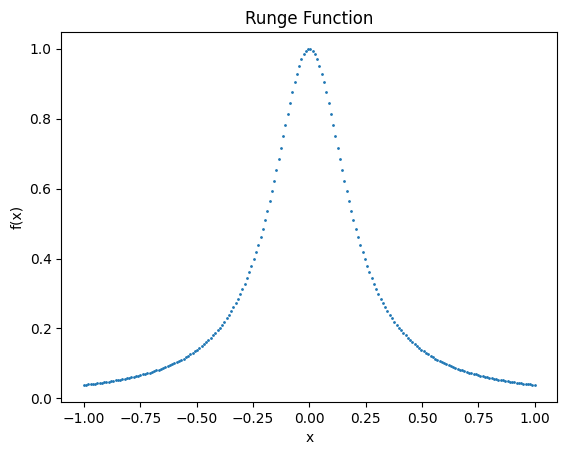

In [21]:
# Plot dataset
plt.scatter(X, y, s=1)
plt.title("Runge Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [28]:
class SimpleNettanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 4)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(4, 4)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        return x
    
class SimpleNetleaky(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 4)
        self.leaky_relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(4, 4)
        self.leaky_relu2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        return x

In [51]:
model = SimpleNettanh()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses_fx, train_losses_dfx = [], []
val_losses_fx, val_losses_dfx = [], []

multiply = 1

for epoch in range(200):
    model.train()
    batch_loss_fx, batch_loss_dfx = [], []

    for xb, yb, dyb in train_loader:
        xb.requires_grad = True
        y_pred = model(xb)

        y_pred_deriv = torch.autograd.grad(
            outputs=y_pred,
            inputs=xb,
            grad_outputs=torch.ones_like(y_pred),
            create_graph=True
        )[0]

        loss_fx = criterion(y_pred, yb)
        loss_dfx = criterion(y_pred_deriv, dyb)
        loss = loss_fx + loss_dfx * multiply

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_fx.append(loss_fx.item())
        batch_loss_dfx.append(loss_dfx.item())

    train_losses_fx.append(np.mean(batch_loss_fx))
    train_losses_dfx.append(np.mean(batch_loss_dfx))

    model.eval()
    X_val_tensor.requires_grad = True
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)

    y_val_pred_deriv = torch.autograd.grad(
        outputs=model(X_val_tensor),
        inputs=X_val_tensor,
        grad_outputs=torch.ones_like(y_val_pred),
        create_graph=False
    )[0]

    val_loss_fx = criterion(y_val_pred, y_val_tensor)
    val_loss_dfx = criterion(y_val_pred_deriv, dy_val_tensor)

    val_losses_fx.append(val_loss_fx.item())
    val_losses_dfx.append(val_loss_dfx.item())

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, "
              f"Train Loss f(x): {train_losses_fx[-1]:.6f}, "
              f"Train Loss f'(x): {train_losses_dfx[-1]:.6f}, "
              f"Val Loss f(x): {val_losses_fx[-1]:.6f}, "
              f"Val Loss f'(x): {val_losses_dfx[-1]:.6f}")

# Evaluation
X_tensor_all = torch.tensor(X, requires_grad=True)
with torch.no_grad():
    y_pred_all = model(X_tensor_all)

y_pred_deriv_all = torch.autograd.grad(
    outputs=model(X_tensor_all),
    inputs=X_tensor_all,
    grad_outputs=torch.ones_like(y_pred_all),
    create_graph=False
)[0].detach().numpy()

true_dy = runge_derivative(X)

Epoch 50, Train Loss f(x): 0.081608, Train Loss f'(x): 1.798998, Val Loss f(x): 0.053912, Val Loss f'(x): 1.868844
Epoch 100, Train Loss f(x): 0.034894, Train Loss f'(x): 1.123422, Val Loss f(x): 0.030866, Val Loss f'(x): 1.026997
Epoch 150, Train Loss f(x): 0.004968, Train Loss f'(x): 0.290966, Val Loss f(x): 0.005367, Val Loss f'(x): 0.259114
Epoch 200, Train Loss f(x): 0.002384, Train Loss f'(x): 0.060841, Val Loss f(x): 0.001656, Val Loss f'(x): 0.070027


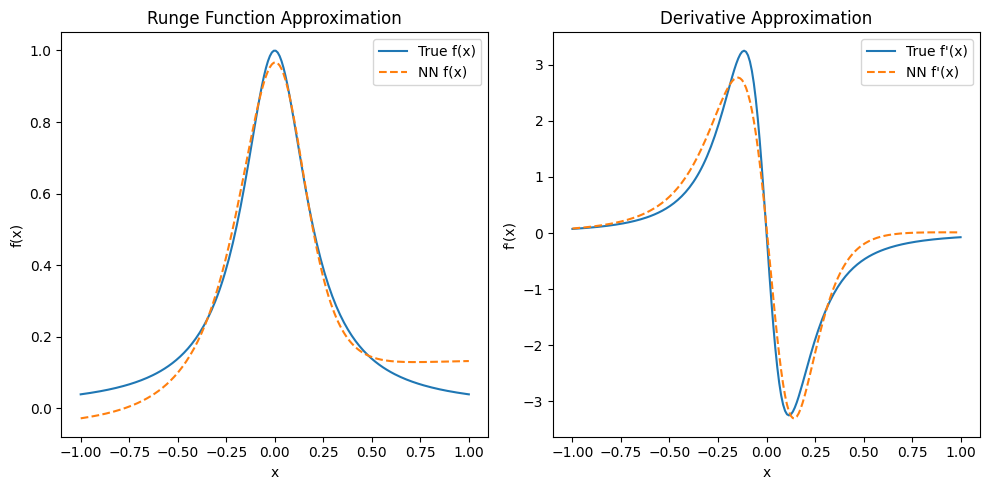

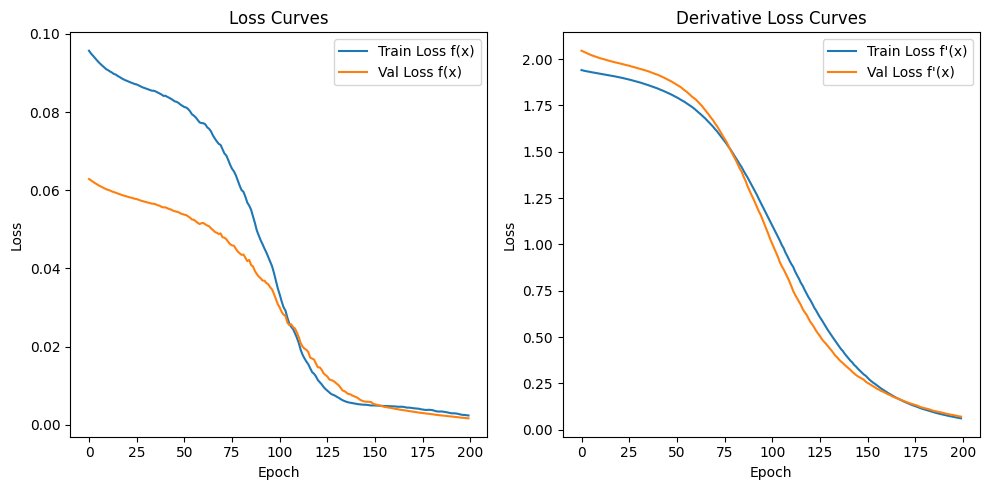

Number of parameters: 33
MSE of f(x): 0.002203
Max error of f(x): 0.093123
MSE of f'(x): 0.061737
Max error of f'(x): 0.706438


In [52]:
# Plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(X, y, label="True f(x)")
plt.plot(X, y_pred_all.numpy(), label="NN f(x)", linestyle="--")
plt.title("Runge Function Approximation")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")

plt.subplot(1, 2, 2)
plt.plot(X, true_dy, label="True f'(x)")
plt.plot(X, y_pred_deriv_all, label="NN f'(x)", linestyle="--")
plt.title("Derivative Approximation")
plt.legend()
plt.xlabel("x")
plt.ylabel("f'(x)")

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_fx, label="Train Loss f(x)")
plt.plot(val_losses_fx, label="Val Loss f(x)")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_dfx, label="Train Loss f'(x)")
plt.plot(val_losses_dfx, label="Val Loss f'(x)")
plt.title("Derivative Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Metrics
mse_fx = mean_squared_error(y, y_pred_all.numpy())
max_error_fx = np.max(np.abs(y - y_pred_all.numpy()))
mse_dfx = mean_squared_error(true_dy, y_pred_deriv_all)
max_error_dfx = np.max(np.abs(true_dy - y_pred_deriv_all))

print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"MSE of f(x): {mse_fx:.6f}")
print(f"Max error of f(x): {max_error_fx:.6f}")
print(f"MSE of f'(x): {mse_dfx:.6f}")
print(f"Max error of f'(x): {max_error_dfx:.6f}")